In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import TransformerModel
from darts.metrics import mse, rmse, r2_score, mae, smape, wmape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, facet_grid
)
import json


torch.set_float32_matmul_precision('medium')


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


In [2]:
target_columns = [
    'Temperature', 'Humidity','Soil_Moisture', 
    'Soil_Temperature', 
    'Precipitation_accumulated'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_mse = float('inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

# Listas para armazenar dados de todos os folds
all_forecasts = []
all_val_scaled = []
all_scalers = []
all_metrics_dfs = []
all_mse_scores = []
all_train_scaled = []
all_metrics_horizon = []

tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")

    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = TransformerModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=72,
        output_chunk_length=24,
        d_model=240,
        nhead=8,
        num_encoder_layers=1,
        num_decoder_layers=3,
        activation="SwiGLU",
        n_epochs=100,
        batch_size=112,
        dropout=0.4,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.HuberLoss(),
        optimizer_cls=torch.optim.Adam,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode": "min", "factor": 0.3, "patience": 5, "min_lr": 1e-7},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr": 3.371095418689331e-05, "weight_decay": 1.302793079680627e-06}
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )

    model.load_from_checkpoint(f"model_{fold+1}/", best=True)

    metrics_per_horizon = []
    for i in [1,4,8,12,16,20,24]:
        forecasts = model.historical_forecasts(
            val_scaled,
            forecast_horizon=i,
            stride=1,
            retrain=False,
            verbose=False,
            last_points_only=True,
        )

        forecasts_t = scaler.inverse_transform(forecasts)
        s = scaler.inverse_transform(val_scaled)
        metrics = {}
        print("Iniciando a verificação das séries temporais para constância...")
        try:
            for target in target_columns:
                metrics[target] = {
                    'MSE': mse(s[target], forecasts_t[target]),
                    'RMSE': rmse(s[target], forecasts_t[target]),
                    'MAE': mae(s[target], forecasts_t[target]),
                    'R2': r2_score(s[target], forecasts_t[target]),
                    'SMAPE': smape(s[target], forecasts_t[target]),
                    'WMAPE': wmape(s[target], forecasts_t[target]),
                }
            metrics_df = pd.DataFrame(metrics).T
            print("\nMétricas de performance:")
            print(metrics_df)
            metrics_per_horizon.append(metrics_df)
        except Exception as e:
            print(e)

    mse_geral = mse(s, forecasts_t)
    print(f"O MSE desse fold foi {mse_geral}")

    # Armazenar dados deste fold
    all_forecasts.append(forecasts)
    all_val_scaled.append(val_scaled)
    all_scalers.append(scaler)
    all_metrics_dfs.append(metrics_df)
    all_metrics_horizon.append(metrics_per_horizon)
    all_mse_scores.append(mse_geral)
    all_train_scaled.append(train_scaled)

    # Ainda mantemos o melhor fold para referência (agora baseado no MSE)
    if best_mse > mse_geral:
        best_mse = mse_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold (baseado no menor MSE) foi {best_fold}")

# Calcular a média dos R2 e MSE de todos os folds
avg_mse = sum(all_mse_scores) / len(all_mse_scores)
print(f"A média dos MSE de todos os folds foi {avg_mse:.4f}")

avg_metrics = {}
metric_names = ['MSE', 'RMSE', 'MAE', 'R2', 'SMAPE', 'WMAPE'] # Definir nomes das métricas

for target in target_columns:
    avg_metrics[target] = {} # Inicializar dicionário para o target atual
    for metric_name in metric_names:
        metric_values_for_fold = []
        # Coletar todos os valores válidos da métrica para o target atual em todos os folds
        for df_fold in all_metrics_dfs:
            # Verificar se o target existe como índice e a métrica como coluna no df_fold
            if target in df_fold.index and metric_name in df_fold.columns:
                value = df_fold.loc[target, metric_name]
                # Adicionar à lista apenas se não for NaN
                if pd.notna(value):
                    metric_values_for_fold.append(value)
        
        # Calcular a média apenas se houver valores válidos
        if metric_values_for_fold:
            avg_metrics[target][metric_name] = sum(metric_values_for_fold) / len(metric_values_for_fold)
        else:
            # Caso contrário, registrar NaN (ou outro valor padrão, se preferir)
            avg_metrics[target][metric_name] = float('nan')

avg_metrics_df = pd.DataFrame(avg_metrics).T
print("\nMétricas médias de performance de todos os folds:")
print(avg_metrics_df)


with open('all_metrics_horizon.json', 'w') as f:
    all_metrics_horizon_dict = [
        [df.to_dict() for df in fold_metrics] for fold_metrics in all_metrics_horizon
    ]
    json.dump(all_metrics_horizon_dict, f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

print("\nUsando a média dos folds para análise...")

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Fold 1

Treinando o modelo...
Train set: 1389 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 10.382
Metric val_loss improved by 0.075 >= min_delta = 0.001. New best score: 10.308
Metric val_loss improved by 0.045 >= min_delta = 0.001. New best score: 10.263
Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 10.239
Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 10.225
Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 10.216
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 10.210
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 10.205
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 10.202
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 10.198
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 10.195
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 10.190
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 10.187
Met

Iniciando a verificação das séries temporais para constância...

Métricas de performance:


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


                                     MSE        RMSE         MAE        R2  \
Temperature                    65.487277    8.092421    6.057132 -0.403773   
Humidity                     2057.231866   45.356718   33.545358 -5.738557   
Soil_Moisture              709811.077609  842.502865  686.443948  0.424255   
Soil_Temperature               54.397559    7.375470    5.711938  0.053176   
Precipitation_accumulated   60155.747127  245.266686  134.857496 -0.431771   

                               SMAPE      WMAPE  
Temperature                50.008865  36.606192  
Humidity                   66.124176  44.109428  
Soil_Moisture               8.667828   8.590125  
Soil_Temperature           39.706991  34.798028  
Precipitation_accumulated  83.958138  97.801700  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    63.551702    7.971932    5.991463 -0.360411   
Humidity                      584.437091   24.175134   18.299951 -0.911967   
Soil_Moisture              631215.850680  794.490938  637.595285  0.488329   
Soil_Temperature              268.561808   16.387855   11.679169 -3.667381   
Precipitation_accumulated   60521.894030  246.011979  135.550749 -0.438626   

                               SMAPE      WMAPE  
Temperature                49.710608  36.187840  
Humidity                   27.994542  24.071415  
Soil_Moisture               8.042415   7.980996  
Soil_Temperature           82.695533  71.107895  
Precipitation_accumulated  87.970937  98.084121  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    39.621136    6.294532    4.833766  0.153358   
Humidity                      557.775148   23.617264   19.483988 -0.822609   
Soil_Moisture              729911.297719  854.348464  710.369765  0.408899   
Soil_Temperature               65.615491    8.100339    6.293972 -0.138015   
Precipitation_accumulated   60176.576785  245.309145  135.184022 -0.427956   

                               SMAPE      WMAPE  
Temperature                33.029515  29.173683  
Humidity                   29.656798  25.642837  
Soil_Moisture               9.014813   8.895066  
Soil_Temperature           37.566919  38.291550  
Precipitation_accumulated  82.856240  97.525732  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    70.047175    8.369419    7.034079 -0.496377   
Humidity                     1333.733640   36.520318   26.515171 -3.348179   
Soil_Moisture              975382.613639  987.614608  816.400803  0.211309   
Soil_Temperature              114.582011   10.704299    8.340056 -0.995817   
Precipitation_accumulated   60627.724031  246.226977  135.990623 -0.436186   

                               SMAPE      WMAPE  
Temperature                40.432133  42.497095  
Humidity                   46.478241  34.891237  
Soil_Moisture              10.486931  10.225862  
Soil_Temperature           43.232801  50.824774  
Precipitation_accumulated  85.644081  97.812828  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                   311.972155   17.662733   13.352001 -5.692294   
Humidity                     1796.264232   42.382358   30.085015 -4.853301   
Soil_Moisture              930706.609503  964.731366  814.078686  0.248187   
Soil_Temperature               88.495747    9.407218    7.272175 -0.551734   
Precipitation_accumulated   60588.288727  246.146884  136.122108 -0.432784   

                               SMAPE      WMAPE  
Temperature                56.044503  80.823716  
Humidity                   57.680148  39.563146  
Soil_Moisture              10.445728  10.200358  
Soil_Temperature           41.277375  44.425861  
Precipitation_accumulated  84.694374  97.612270  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    83.969248    9.163474    7.450966 -0.800037   
Humidity                     1047.907384   32.371398   25.496109 -2.407586   
Soil_Moisture              766989.550481  875.779396  730.184149  0.380921   
Soil_Temperature               82.634771    9.090367    7.597038 -0.446037   
Precipitation_accumulated   60978.359095  246.937966  136.785309 -0.439530   

                               SMAPE      WMAPE  
Temperature                42.112872  45.148103  
Humidity                   41.373932  33.519454  
Soil_Moisture               9.221242   9.152570  
Soil_Temperature           44.131361  46.443734  
Precipitation_accumulated  85.840022  97.791243  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    56.761065    7.533994    6.255110 -0.213229   
Humidity                      598.909232   24.472622   19.938795 -0.941891   
Soil_Moisture              708374.449892  841.649838  703.295284  0.428687   
Soil_Temperature              236.596532   15.381695   11.896088 -3.128571   
Precipitation_accumulated   61042.108952  247.067013  137.050701 -0.438559   

                               SMAPE      WMAPE  
Temperature                36.721079  37.894201  
Humidity                   29.861015  26.217384  
Soil_Moisture               9.053813   8.818815  
Soil_Temperature           52.762914  72.698292  
Precipitation_accumulated  85.610233  97.683763  
O MSE desse fold foi 154061.76513477878

Fold 2

Treinando o modelo...
Train set: 2773 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 0.150
Metric val_loss improved by 0.056 >= min_delta = 0.001. New best score: 0.094
Metric val_loss improved by 0.027 >= min_delta = 0.001. New best score: 0.066
Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 0.047
Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.035
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.026
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.020
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.018
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.017
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.017. Signaling Trainer to stop.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.sel

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    27.952414    5.287004    4.704896   
Humidity                      161.346042   12.702206   10.631121   
Soil_Moisture              191460.292537  437.561759  380.743943   
Soil_Temperature               62.108938    7.880922    6.891028   
Precipitation_accumulated   10755.182295  103.707195   96.603393   

                                     R2      SMAPE      WMAPE  
Temperature               -2.544112e+00  38.114952  30.349227  
Humidity                  -6.751463e+00  11.670830  12.366647  
Soil_Moisture             -3.391536e+01   5.996978   5.966763  
Soil_Temperature          -6.256781e+00  62.242540  44.409513  
Precipitation_accumulated -2.986372e+06  18.821387  21.086782  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    31.688907    5.629290    5.357322   
Humidity                       47.700391    6.906547    5.699013   
Soil_Moisture              316889.500904  562.929392  474.511810   
Soil_Temperature              135.822395   11.654287   11.387476   
Precipitation_accumulated   24117.308183  155.297483  147.814444   

                                     R2       SMAPE      WMAPE  
Temperature               -3.034872e+00   42.388823  34.581909  
Humidity                  -1.288439e+00    6.454704   6.628873  
Soil_Moisture             -5.714986e+01    7.778407   7.435850  
Soil_Temperature          -1.493090e+01  125.779877  73.438975  
Precipitation_accumulated -7.323059e+06   27.427514  32.265172  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    65.356611    8.084344    7.917534   
Humidity                      298.696786   17.282847   14.902150   
Soil_Moisture              100851.690077  317.571551  257.739484   
Soil_Temperature               54.558365    7.386363    6.945881   
Precipitation_accumulated   38245.794036  195.565319  178.458998   

                                     R2      SMAPE      WMAPE  
Temperature               -7.364034e+00  70.760365  51.154372  
Humidity                  -1.330107e+01  15.732160  17.331970  
Soil_Moisture             -1.766895e+01   3.959795   4.038633  
Soil_Temperature          -5.430485e+00  60.627383  44.836219  
Precipitation_accumulated -1.328861e+07  31.689075  38.954218  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    11.271317    3.357278    3.009477   
Humidity                      111.136472   10.542128    8.897891   
Soil_Moisture              198720.725714  445.781029  393.868495   
Soil_Temperature               24.135120    4.912751    4.412726   
Precipitation_accumulated   27840.505824  166.854745  154.102298   

                                     R2      SMAPE      WMAPE  
Temperature               -4.489805e-01  21.219505  19.460865  
Humidity                  -4.312072e+00  10.088093  10.347572  
Soil_Moisture             -3.609988e+01   6.288501   6.171276  
Soil_Temperature          -1.857560e+00  34.893409  28.510348  
Precipitation_accumulated -1.132804e+07  28.157425  33.637527  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    12.639298    3.555179    3.032807   
Humidity                       99.047095    9.952241    8.230468   
Soil_Moisture              366438.077827  605.341290  476.989359   
Soil_Temperature              162.134991   12.733224   12.496848   
Precipitation_accumulated   27541.826705  165.957304  155.946594   

                                     R2       SMAPE      WMAPE  
Temperature               -6.310979e-01   20.808658  19.628051  
Humidity                  -3.725954e+00    9.221037   9.570379  
Soil_Moisture             -6.800568e+01    7.069059   7.473130  
Soil_Temperature          -1.827580e+01  138.488429  80.812726  
Precipitation_accumulated -1.355412e+07   28.584945  34.040016  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    22.748318    4.769520    4.478280   
Humidity                       54.766737    7.400455    6.594534   
Soil_Moisture              193621.168992  440.024055  385.849852   
Soil_Temperature               49.820715    7.058379    6.549026   
Precipitation_accumulated   24982.919662  158.059861  145.096921   

                                     R2      SMAPE      WMAPE  
Temperature               -1.953369e+00  33.702887  29.010557  
Humidity                  -1.610178e+00   7.438412   7.667119  
Soil_Moisture             -3.587966e+01   6.135045   6.045326  
Soil_Temperature          -4.956467e+00  59.268349  42.391299  
Precipitation_accumulated -1.388166e+07  26.716875  31.671691  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    14.529677    3.811781    3.225793   
Humidity                      123.124078   11.096129    8.976679   
Soil_Moisture              221008.254267  470.115150  406.527917   
Soil_Temperature               28.295253    5.319328    4.238744   
Precipitation_accumulated   58661.063750  242.200462  224.898748   

                                     R2      SMAPE      WMAPE  
Temperature               -9.102773e-01  23.005212  20.923002  
Humidity                  -4.880747e+00  10.651829  10.434535  
Soil_Moisture             -4.187262e+01   6.595119   6.369887  
Soil_Temperature          -2.418781e+00  26.099837  27.470357  
Precipitation_accumulated -3.371510e+07  38.358491  49.090755  
O MSE desse fold foi 55967.0534050759

Fold 3

Treinando o modelo...
Train set: 4157 samples
Validation set: 1384 sam

Metric val_loss improved. New best score: 0.071
Metric val_loss improved by 0.046 >= min_delta = 0.001. New best score: 0.025
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.015
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.011
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.010
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.009
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.007
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.006
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.005
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.004
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.003. Signaling Trainer to stop.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    2.009025    1.417401    1.212597    -2.619780   
Humidity                      35.591345    5.965848    5.017386    -2.710143   
Soil_Moisture              88700.063065  297.825558  225.870057    -1.667912   
Soil_Temperature               4.634645    2.152822    1.904219   -23.157743   
Precipitation_accumulated    131.441367   11.464788    9.000158 -3273.863673   

                               SMAPE      WMAPE  
Temperature                12.547335  13.080212  
Humidity                    5.406437   5.510145  
Soil_Moisture               3.783298   3.808801  
Soil_Temperature           17.440786  19.473464  
Precipitation_accumulated   1.987369   1.963263  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    4.545500    2.132018    1.666492    -7.233435   
Humidity                      44.666736    6.683318    5.965435    -3.652119   
Soil_Moisture              51629.211884  227.220624  173.851112    -0.573375   
Soil_Temperature              10.750072    3.278730    3.194527   -55.590313   
Precipitation_accumulated    241.792297   15.549672   12.609822 -6028.367511   

                               SMAPE      WMAPE  
Temperature                21.207385  17.982357  
Humidity                    6.365290   6.551702  
Soil_Moisture               2.946456   2.932149  
Soil_Temperature           27.980275  32.676466  
Precipitation_accumulated   2.770022   2.750660  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    2.133660    1.460705    1.148331     -2.932450   
Humidity                      47.582144    6.897981    6.215997     -3.946572   
Soil_Moisture              51002.230719  225.836735  179.730485     -0.584019   
Soil_Temperature               3.674830    1.916985    1.662804    -18.822736   
Precipitation_accumulated    621.072428   24.921325   20.158684 -15504.126664   

                               SMAPE      WMAPE  
Temperature                13.459871  12.398885  
Humidity                    6.633657   6.827332  
Soil_Moisture               3.033428   3.032067  
Soil_Temperature           15.526313  17.015482  
Precipitation_accumulated   4.547518   4.397334  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                     3.917687    1.979315    1.597542    -6.269033   
Humidity                       29.843513    5.462922    4.206490    -2.096118   
Soil_Moisture              194881.930721  441.454336  372.507922    -5.106105   
Soil_Temperature                1.982321    1.407949    1.152348    -9.802786   
Precipitation_accumulated     154.947610   12.447795   10.379153 -3871.904212   

                               SMAPE      WMAPE  
Temperature                18.794687  17.256639  
Humidity                    4.549277   4.620470  
Soil_Moisture               6.123409   6.285321  
Soil_Temperature           11.186781  11.795277  
Precipitation_accumulated   2.294299   2.264063  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                     3.718453    1.928329    1.633741   
Humidity                       98.421909    9.920782    9.410923   
Soil_Moisture              268208.490933  517.888493  422.620585   
Soil_Temperature                2.472334    1.572366    1.253913   
Precipitation_accumulated     474.042575   21.772519   17.189595   

                                     R2      SMAPE      WMAPE  
Temperature                   -5.960217  16.088289  17.656101  
Humidity                      -9.192987   9.863622  10.337809  
Soil_Moisture                 -7.419826   6.894151   7.131715  
Soil_Temperature             -12.658623  13.165178  12.838910  
Precipitation_accumulated -11862.240881   3.864000   3.749657  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                     3.637610    1.907252    1.472774   
Humidity                       28.769695    5.363739    4.583829   
Soil_Moisture              126123.740008  355.139043  290.619322   
Soil_Temperature                2.423401    1.556728    1.189556   
Precipitation_accumulated     945.872137   30.755034   21.531583   

                                     R2      SMAPE      WMAPE  
Temperature                   -5.874503  18.469963  15.924354  
Humidity                      -1.974103   4.937030   5.035633  
Soil_Moisture                 -2.967158   4.823267   4.904779  
Soil_Temperature             -12.598249  13.632255  12.183968  
Precipitation_accumulated -23700.082553   4.920261   4.696790  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                     5.234164    2.287830    1.760327   
Humidity                       63.136809    7.945867    7.075595   
Soil_Moisture              141928.149431  376.733526  312.846357   
Soil_Temperature                1.315598    1.146995    1.002520   
Precipitation_accumulated     585.579910   24.198758   17.360452   

                                     R2      SMAPE      WMAPE  
Temperature                   -8.989676  23.222216  19.042978  
Humidity                      -5.513914   7.496470   7.773493  
Soil_Moisture                 -3.473322   5.185968   5.280538  
Soil_Temperature              -6.502405  10.929695  10.271674  
Precipitation_accumulated -14691.225974   3.905925   3.786914  
O MSE desse fold foi 28516.683182347566

Fold 4

Treinando o modelo...
Train set: 5541 samples
Validation set: 1384 s

Metric val_loss improved. New best score: 0.047
Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 0.021
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.016
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.015
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE          R2  \
Temperature                1.813426e+01     4.258434    3.894720   -2.426330   
Humidity                   2.230041e+02    14.933323   13.057854   -1.628260   
Soil_Moisture              1.289317e+06  1135.481111  736.186468    0.067472   
Soil_Temperature           2.139234e+01     4.625185    3.947911   -2.622979   
Precipitation_accumulated  5.241001e+02    22.893232   21.313293 -448.174168   

                               SMAPE      WMAPE  
Temperature                58.582994  69.353974  
Humidity                   14.908901  15.502493  
Soil_Moisture              10.533622  11.242509  
Soil_Temperature           61.471439  72.683480  
Precipitation_accumulated   4.582410   4.632675  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE           R2  \
Temperature                1.383186e+01     3.719121    2.877088    -1.609845   
Humidity                   1.450211e+02    12.042472   10.953543    -0.705428   
Soil_Moisture              1.524333e+06  1234.638621  831.118267    -0.101200   
Soil_Temperature           2.381334e+01     4.879891    4.484986    -3.038746   
Precipitation_accumulated  1.458802e+03    38.194268   33.084329 -1251.406356   

                               SMAPE      WMAPE  
Temperature                46.797395  51.262886  
Humidity                   12.693180  13.003562  
Soil_Moisture              12.121551  12.688620  
Soil_Temperature           66.651499  82.679101  
Precipitation_accumulated   6.871049   7.191187  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE          R2  \
Temperature                8.176955e+00     2.859537    2.427862   -0.539265   
Humidity                   2.124654e+02    14.576194   12.622003   -1.491599   
Soil_Moisture              1.455092e+06  1206.272137  790.700580   -0.049522   
Soil_Temperature           3.309645e+01     5.752952    5.401784   -4.621597   
Precipitation_accumulated  4.558197e+02    21.349935   17.496300 -391.247071   

                               SMAPE      WMAPE  
Temperature                43.662251  43.284739  
Humidity                   14.460623  14.982797  
Soil_Moisture              11.414704  12.066949  
Soil_Temperature           74.237741  99.746586  
Precipitation_accumulated   3.853462   3.802947  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE          R2  \
Temperature                5.688546e+00     2.385067    1.701985   -0.068845   
Humidity                   1.325946e+02    11.514974   10.415830   -0.550786   
Soil_Moisture              1.304441e+06  1142.121128  723.674049    0.060616   
Soil_Temperature           1.834323e+01     4.282900    3.503333   -2.119721   
Precipitation_accumulated  5.405499e+02    23.249730   20.545038 -465.276289   

                               SMAPE      WMAPE  
Temperature                34.095998  30.365260  
Humidity                   12.115132  12.362589  
Soil_Moisture              10.289582  11.039794  
Soil_Temperature           57.790917  64.796889  
Precipitation_accumulated   4.349172   4.465570  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE          R2  \
Temperature                1.033022e+01     3.214065    2.883621   -0.947226   
Humidity                   2.420620e+02    15.558341   13.617682   -1.824701   
Soil_Moisture              1.401790e+06  1183.972130  765.613113   -0.007899   
Soil_Temperature           1.233544e+01     3.512184    2.933690   -1.101754   
Precipitation_accumulated  2.318523e+02    15.226697   13.979244 -199.485792   

                               SMAPE      WMAPE  
Temperature                49.387375  51.535109  
Humidity                   15.455123  16.160188  
Soil_Moisture              10.992470  11.675067  
Soil_Temperature           52.016335  54.355407  
Precipitation_accumulated   2.986129   3.038431  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE          R2  \
Temperature                7.784587e+00     2.790087    2.274203   -0.465101   
Humidity                   2.027164e+02    14.237852   12.269769   -1.359146   
Soil_Moisture              1.558166e+06  1248.265234  806.712613   -0.118581   
Soil_Temperature           1.396463e+01     3.736927    3.264155   -1.383086   
Precipitation_accumulated  5.975751e+02    24.445349   21.572680 -517.028333   

                               SMAPE      WMAPE  
Temperature                43.034242  40.679517  
Humidity                   14.092635  14.558899  
Soil_Moisture              11.636645  12.297008  
Soil_Temperature           55.553403  60.581325  
Precipitation_accumulated   4.560159   4.688842  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE          R2  \
Temperature                5.259597e+00     2.293381    1.613999    0.012179   
Humidity                   1.922513e+02    13.865472   12.076493   -1.231137   
Soil_Moisture              1.553717e+06  1246.481712  825.551567   -0.113645   
Soil_Temperature           8.210102e+00     2.865328    2.013959   -0.403204   
Precipitation_accumulated  6.725497e+02    25.933563   23.365790 -583.519449   

                               SMAPE      WMAPE  
Temperature                32.834004  28.891028  
Humidity                   13.887104  14.328007  
Soil_Moisture              11.983993  12.579238  
Soil_Temperature           42.350555  37.441813  
Precipitation_accumulated   4.941887   5.078527  
O MSE desse fold foi 310918.98573807563

Fold 5

Treinando o modelo...
Train set: 6925 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 0.030
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.022
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.020
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.019
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.017
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.015
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.013
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.011
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.010
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.009
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.008
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.008. Signaling Trainer to stop.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    16.778598    4.096169    3.279825     0.399420   
Humidity                      144.701050   12.029175    9.575112     0.069567   
Soil_Moisture              454114.423820  673.880126  609.713906   -72.463684   
Soil_Temperature               49.909917    7.064695    6.315590    -2.831680   
Precipitation_accumulated    1887.611200   43.446648   38.696996 -1254.561318   

                                SMAPE      WMAPE  
Temperature                 40.967311  32.588959  
Humidity                    11.392285  11.125228  
Soil_Moisture                6.744852   7.036874  
Soil_Temperature           118.421278  72.127035  
Precipitation_accumulated    8.779456   8.318323  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    11.445052    3.383054    2.655768     0.590286   
Humidity                      160.164843   12.655625   10.201595    -0.029660   
Soil_Moisture              622120.171524  788.745949  715.279533   -99.700893   
Soil_Temperature               16.064795    4.008091    3.422556    -0.235349   
Precipitation_accumulated    1932.396113   43.959028   36.923272 -1298.512102   

                               SMAPE      WMAPE  
Temperature                31.281519  26.356422  
Humidity                   12.042377  11.849495  
Soil_Moisture               7.850597   8.255045  
Soil_Temperature           65.776202  39.039204  
Precipitation_accumulated   8.410143   7.936928  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    21.475932    4.634213    3.753405     0.228250   
Humidity                      178.146825   13.347165   10.772293    -0.142213   
Soil_Moisture              659386.733893  812.026314  741.417973  -105.709082   
Soil_Temperature                7.418685    2.723726    2.279032     0.426085   
Precipitation_accumulated    1854.687973   43.066088   37.846282 -1265.074333   

                               SMAPE      WMAPE  
Temperature                47.785927  37.160546  
Humidity                   12.621100  12.510574  
Soil_Moisture               8.129889   8.556481  
Soil_Temperature           34.375449  25.939654  
Precipitation_accumulated   8.590776   8.135178  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    11.793511    3.434168    2.722014     0.572772   
Humidity                      104.909307   10.242524    8.765693     0.329354   
Soil_Moisture              389984.384027  624.487297  592.053191   -62.161108   
Soil_Temperature               36.528535    6.043884    5.432982    -1.855183   
Precipitation_accumulated    1475.527582   38.412597   32.333801 -1021.890564   

                                SMAPE      WMAPE  
Temperature                 32.197145  26.869437  
Humidity                    10.436302  10.180820  
Soil_Moisture                6.576668   6.832495  
Soil_Temperature           108.642450  61.676252  
Precipitation_accumulated    7.295114   6.950117  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                    25.959019    5.094999    4.251004    0.050060   
Humidity                      140.686265   11.861124    9.538245    0.101890   
Soil_Moisture              393673.491088  627.434053  555.060197  -62.887834   
Soil_Temperature               37.455012    6.120050    5.531203   -1.964741   
Precipitation_accumulated     814.400790   28.537708   23.178569 -572.603093   

                                SMAPE      WMAPE  
Temperature                 59.325865  41.845865  
Humidity                    11.316677  11.081729  
Soil_Moisture                6.156192   6.405354  
Soil_Temperature           103.843787  62.615135  
Precipitation_accumulated    5.150084   4.982111  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    20.422776    4.519157    3.628344     0.251054   
Humidity                      128.295187   11.326747    9.163759     0.183111   
Soil_Moisture              418874.649799  647.205261  597.930167   -67.202850   
Soil_Temperature               28.818963    5.368330    4.882802    -1.300197   
Precipitation_accumulated    3034.133456   55.082969   49.501029 -2171.234160   

                               SMAPE      WMAPE  
Temperature                43.790119  35.644637  
Humidity                   10.937554  10.647875  
Soil_Moisture               6.625732   6.899793  
Soil_Temperature           96.940657  55.144368  
Precipitation_accumulated  11.389020  10.639775  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                    22.569730    4.750761    3.819447    0.172771   
Humidity                      140.695563   11.861516    9.437735    0.106807   
Soil_Moisture              567358.010123  753.231711  690.410771  -91.711669   
Soil_Temperature               17.024246    4.126045    3.440983   -0.363048   
Precipitation_accumulated    1079.383258   32.853969   26.936941 -784.892929   

                               SMAPE      WMAPE  
Temperature                46.046284  37.468623  
Humidity                   11.260098  10.966085  
Soil_Moisture               7.602668   7.966642  
Soil_Temperature           63.530214  38.793147  
Precipitation_accumulated   6.023755   5.789724  
O MSE desse fold foi 113723.53658399804
O melhor fold (baseado no menor MSE) foi 3
A média dos MSE de todos os folds foi 132637.6

In [5]:
# Ainda carregamos o modelo do melhor fold para previsões
model.load_from_checkpoint(f"model_{best_fold}/", best=True)

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)


TransformerModel(output_chunk_shift=0, d_model=240, nhead=8, num_encoder_layers=1, num_decoder_layers=3, dim_feedforward=512, dropout=0.4, activation=SwiGLU, norm_type=None, custom_encoder=None, custom_decoder=None, model_name=model_3, input_chunk_length=72, output_chunk_length=24, n_epochs=100, batch_size=112, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x79de9ce88110>]}, loss_fn=HuberLoss(), optimizer_cls=<class 'torch.optim.adam.Adam'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.3, 'patience': 5, 'min_lr': 1e-07}, save_checkpoints=True, show_warnings=True, force_reset=True, random_state=42, optimizer_kwarg

In [6]:
# Preparar dados para visualização usando a média dos folds
# Primeiro, vamos transformar os dados de cada fold
all_s_dfs = []
all_forecasts_dfs = []

for i, (val_scaled, forecasts, scaler) in enumerate(zip(all_val_scaled, all_forecasts, all_scalers)):
    # Transformar dados de validação
    s_fold = scaler.inverse_transform(val_scaled)
    s_fold_df = s_fold.to_dataframe()
    s_fold_df = s_fold_df.reset_index()
    s_fold_df['fold'] = i + 1
    all_s_dfs.append(s_fold_df)

    # Transformar previsões
    forecasts_fold = scaler.inverse_transform(forecasts)
    forecasts_fold_df = forecasts_fold.to_dataframe()
    forecasts_fold_df = forecasts_fold_df.reset_index()
    forecasts_fold_df['fold'] = i + 1
    all_forecasts_dfs.append(forecasts_fold_df)

# Combinar todos os dataframes
s_df = pd.concat(all_s_dfs)
forecasts_t_df = pd.concat(all_forecasts_dfs)

# Renomear colunas para consistência
s_df = s_df.rename(columns={"time": "Timestamp"})
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})

# Para referência, também mantemos os dados do melhor fold
s_best = best_scaler.inverse_transform(best_val_scaled)
forecasts_t_best = best_scaler.inverse_transform(best_forecasts)
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Humidity', 'Soil_Moisture',
       'Soil_Temperature', 'Precipitation_accumulated', 'fold'],
      dtype='object', name='component')


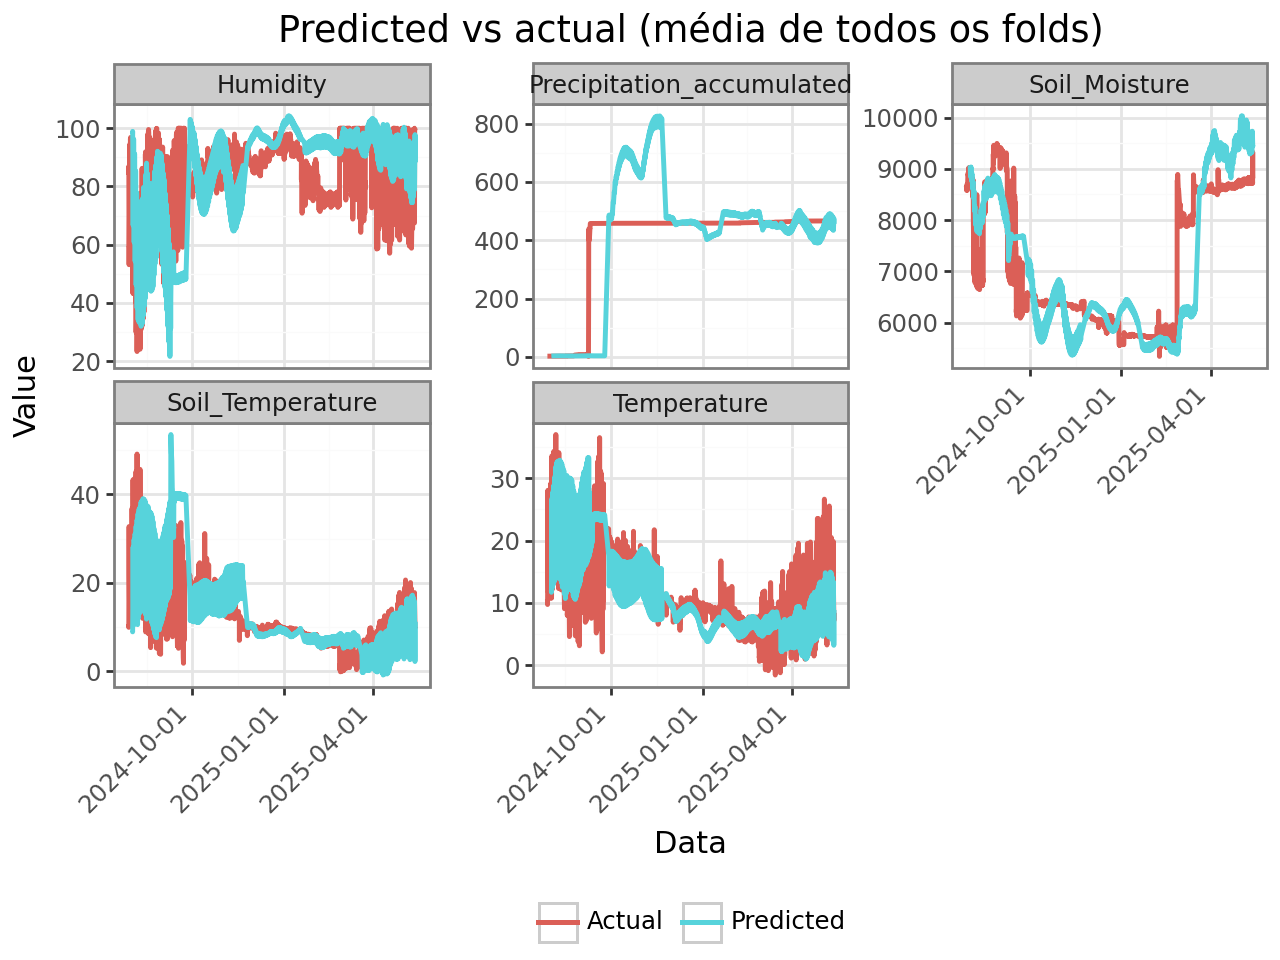

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_avg.png


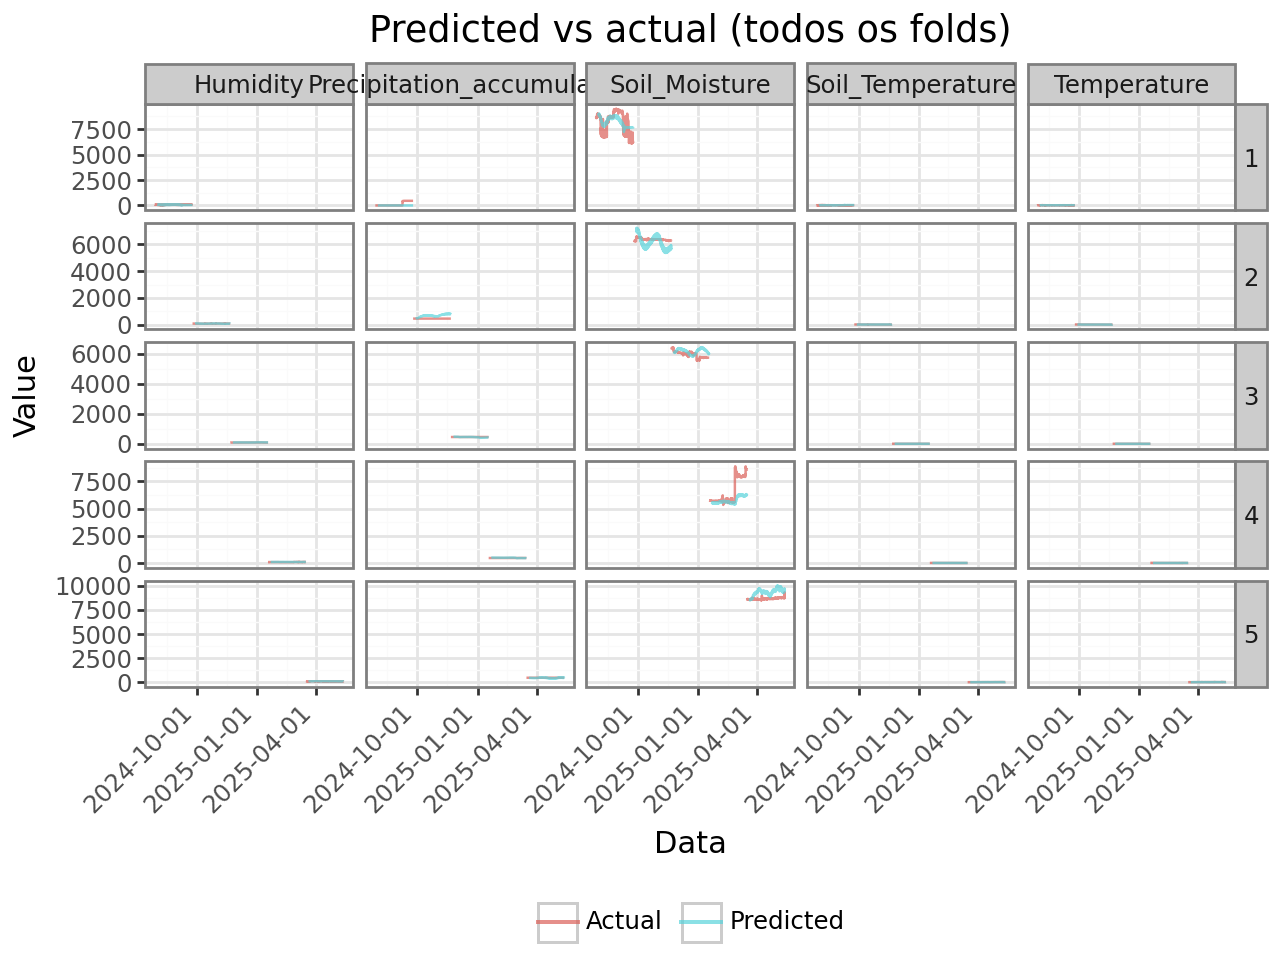

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 15 x 20 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_all_folds.png
/tmp/ipykernel_193232/688565223.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


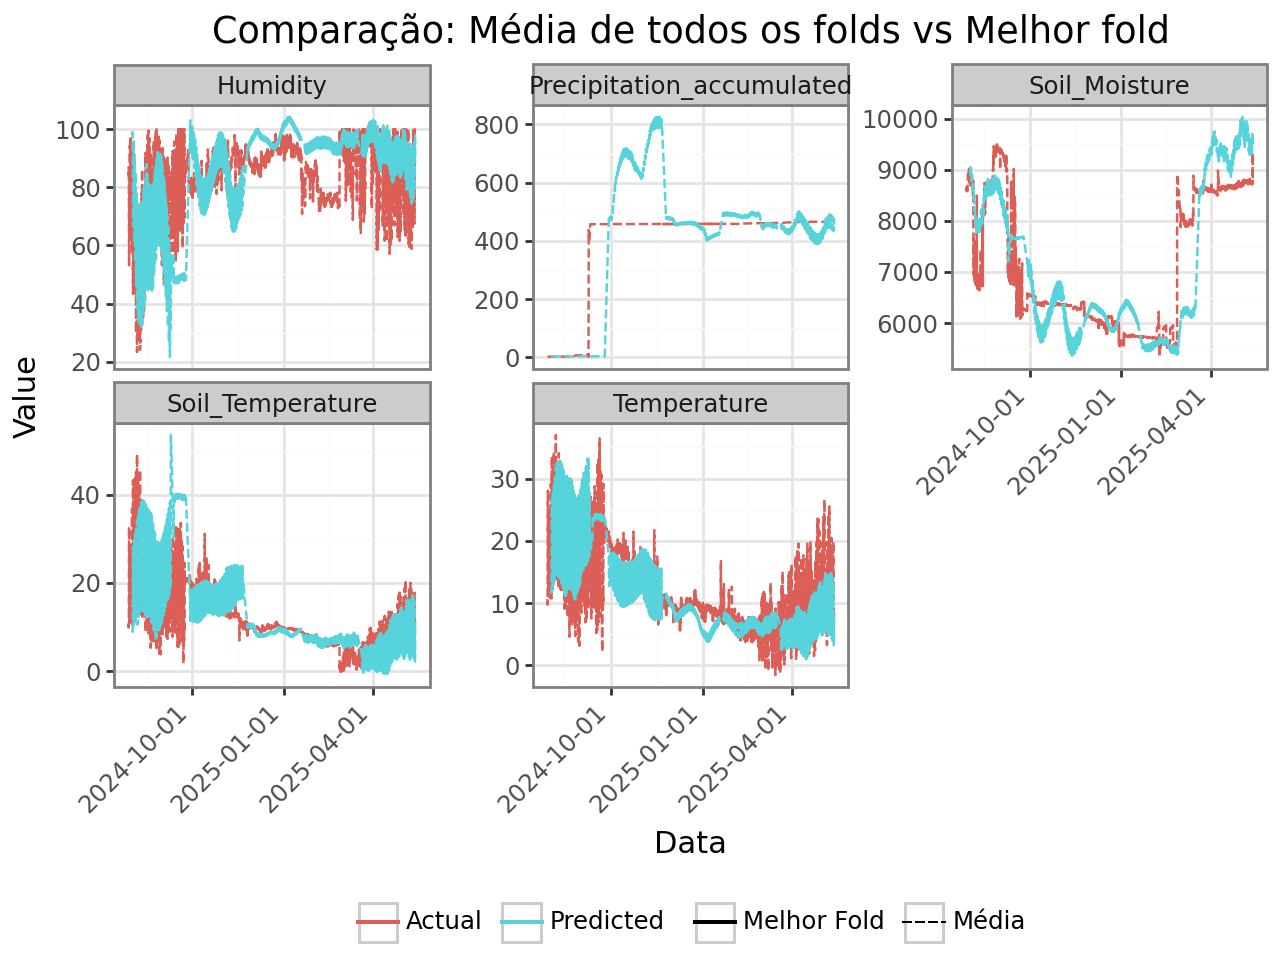

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_comparison.png


In [7]:
plot_columns = ['Timestamp', 'fold'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

# Também criar uma versão agregada (média) para cada target e timestamp
df_avg = df_combined.groupby(['Date', 'target_column', 'type']).agg({'value': 'mean'}).reset_index()
df_avg['fold'] = 'Média'

# Combinar os dados médios com os dados originais
df_all = pd.concat([df_combined, df_avg])

# Plot 1: Média de todos os folds
plot_avg = (
    ggplot(df_avg, aes(x='Date', y='value', color='type'))
    + geom_line(size=1)
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (média de todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_avg.show()
plot_avg.save('predict_actual_avg.png', width=12, height=10, dpi=300)

# Plot 2: Todos os folds separados por target
plot_all_folds = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line(alpha=0.7)
    + facet_grid('fold ~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
        strip_text_y=element_text(angle=0)
    )
)
plot_all_folds.show()
plot_all_folds.save('predict_actual_all_folds.png', width=15, height=20, dpi=300)

# Plot 3: Comparação da média com o melhor fold
# Primeiro, preparar os dados do melhor fold
best_fold_data = df_combined[df_combined['fold'] == best_fold]
best_fold_data['fold'] = 'Melhor Fold'
comparison_data = pd.concat([df_avg, best_fold_data])

plot_comparison = (
    ggplot(comparison_data, aes(x='Date', y='value', color='type', linetype='fold'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Comparação: Média de todos os folds vs Melhor fold',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_comparison.show()
plot_comparison.save('predict_actual_comparison.png', width=12, height=10, dpi=300)

In [8]:
# Salvar métricas do melhor fold
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

# Salvar todas as métricas em um único arquivo
all_metrics = {
    'average': avg_metrics_df.to_dict(),
    'best_fold': best_metrics.to_dict(),
    'all_folds': {f'fold_{i+1}': df.to_dict() for i, df in enumerate(all_metrics_dfs)}
}
with open('all_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=4)

print("\nAnálise completa! Os resultados foram salvos usando a média de todos os folds.")



Análise completa! Os resultados foram salvos usando a média de todos os folds.
